In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Load data

In [5]:
df_1min = load_pkl('experiments/feat_engin//data/data_shift_time_1min.pkl')
# df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
# df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
# df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')

In [66]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-19')))

In [68]:
#Оставим каждый 1час
mask_freq_min = np.array(df_1min['time'].dt.minute % 5 == 0) & np.array(df_1min['ticker'] == 'SNGS')

mask_train &= mask_freq_min
mask_valid &= mask_freq_min
mask_test &= mask_freq_min
mask_test2 &= mask_freq_min

In [71]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(26470, 6700, 6655, 5120)

In [73]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

44945

In [75]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.5889420402714429,
 0.1490710868839693,
 0.1480698631660919,
 0.11391700967849594)

In [77]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

In [79]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.4118247072157159, 0.4808955223880597, 0.42839969947407963, 0.4404296875)

In [32]:
# import keras

# model = keras.saving.load_model('./best_models/model_0004.keras',
#                                 custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})


# AUC_ROC:  [0.667, 0.581, 0.56, 0.588]
# PRECISION:  [0.455, 0.511, 0.461, 0.47]

# Evaluate

In [85]:
df = df_1min.copy()
df.head()

,time,close,volume,close_w1_roc,close_w1_diff,volume_w1_roc,volume_w1_diff,close_w60_ma,close_w60_std,close_w60_min,...,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target
index,,,,,,,,,,,,,,,,,,,,,
0,2022-10-03 10:01:00,219.929993,87793.0,NaN,NaN,NaN,NaN,219.929993,NaN,219.929993,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0
1,2022-10-03 10:02:00,220.800003,61549.0,0.003956,0.87,-0.298930,-26244.0,220.365005,0.615183,219.929993,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0
2,2022-10-03 10:03:00,219.339996,52640.0,-0.006612,-1.46,-0.144746,-8909.0,220.023331,0.734461,219.339996,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0
3,2022-10-03 10:04:00,218.960007,61506.0,-0.001732,-0.38,0.168427,8866.0,219.757507,0.801431,218.960007,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0
4,2022-10-03 10:05:00,218.300003,51464.0,-0.003014,-0.66,-0.163269,-10042.0,219.466003,0.952145,218.300003,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0


In [86]:
df['sample'] = None
df.loc[mask_valid, 'sample'] = 'valid'
df.loc[mask_test, 'sample'] = 'test'
df.loc[mask_test2, 'sample'] = 'test2'

### load data

In [89]:
#load data

y_pred_valid = load_pkl('./best_models/model_1hour_5min_1day_SNGS/model_5min_keras003/y_pred_valid.pkl')
y_pred_test = load_pkl('./best_models/model_1hour_5min_1day_SNGS/model_5min_keras003/y_pred_test.pkl')
y_pred_test2 = load_pkl('./best_models/model_1hour_5min_1day_SNGS/model_5min_keras003/y_pred_test2.pkl')


df['y_pred'] = None
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

In [91]:
####### 5 min
#Epoch 3/5
# AUC_ROC:  [0.648, 0.521, 0.566, 0.584]
# PRECISION:  [0.938, 0.657, 0.612, 0.615]
# PRECISION_5:  [0.681, 0.597, 0.468, 0.637]

### auc_roc

In [96]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.5211000403708118, 0.5662911919406957, 0.5838574739864486)

### target

In [100]:
q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

0.6567164179104478
0.6119402985074627
0.6153846153846154


In [103]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

threshokd = 0.5131492990255356
0.6567164179104478
0.5431034482758621
0.5263157894736842


In [ ]:
df

### Посомтрим на вероятности

In [105]:
#mask_freq_min = np.array(df['time'].dt.minute == 0)
df = df[mask_freq_min]
df.reset_index(inplace=True, drop=True)

mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

In [107]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.5211000403708118, 0.5662911919406957, 0.5838574739864486)

76744 SNGS
34


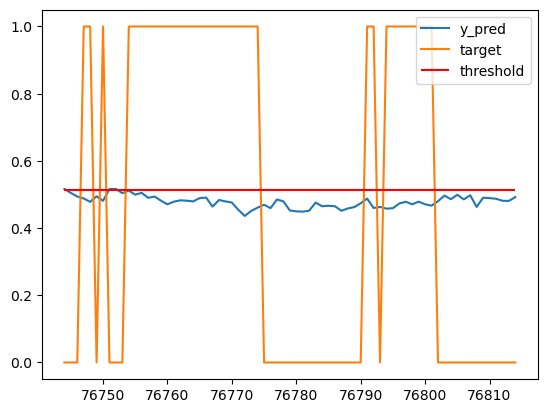

70433 SNGS
61


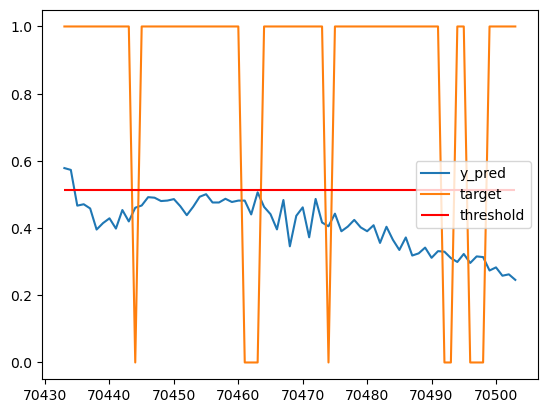

77183 SNGS
31


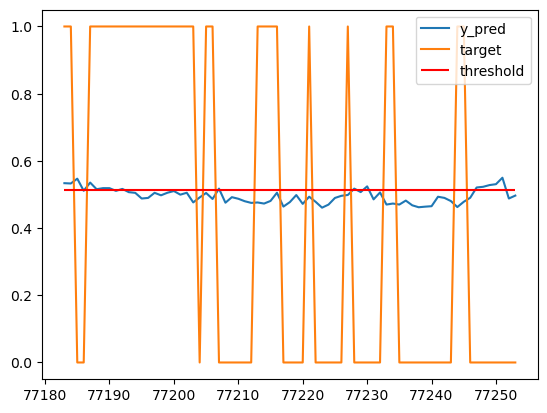

69633 SNGS
15


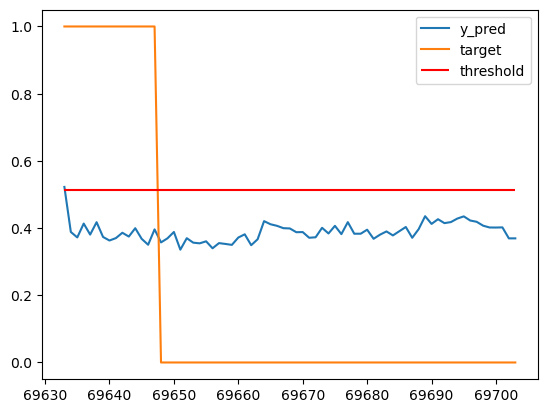

77276 SNGS
48


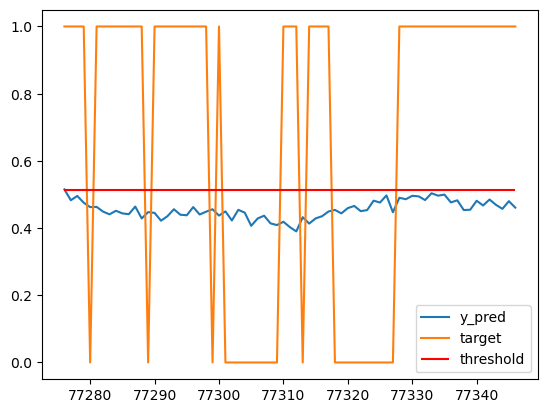

81108 SNGS
63


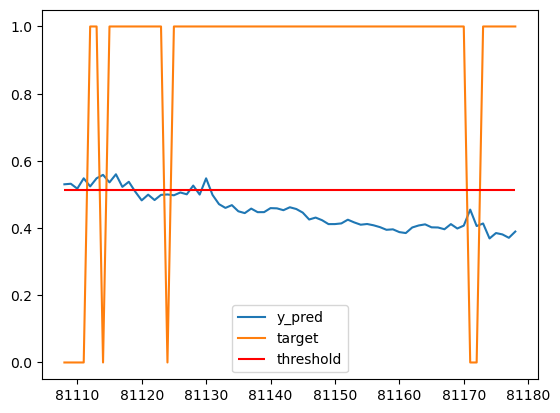

69996 SNGS
43


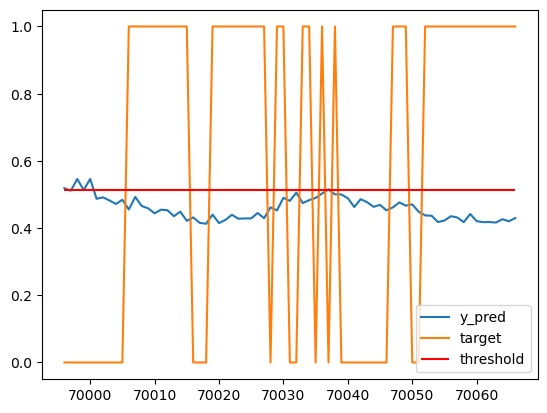

69998 SNGS
45


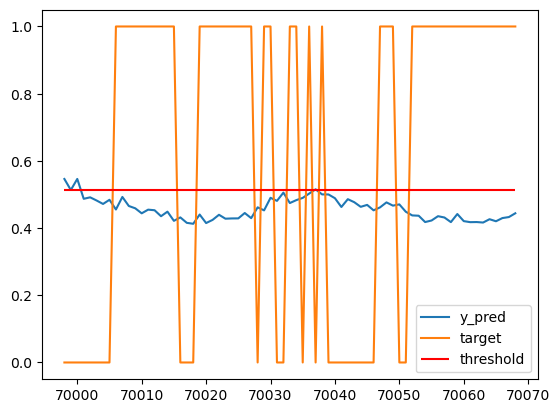

76632 SNGS
51


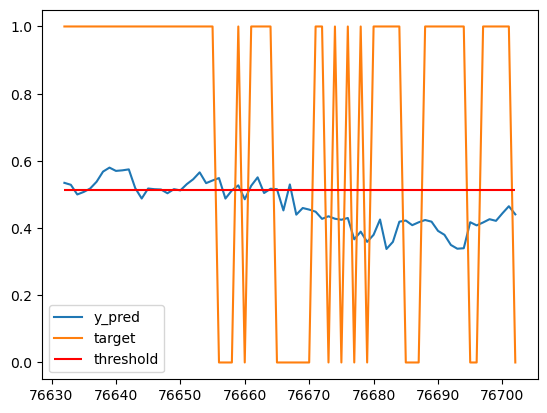

67002 SNGS
60


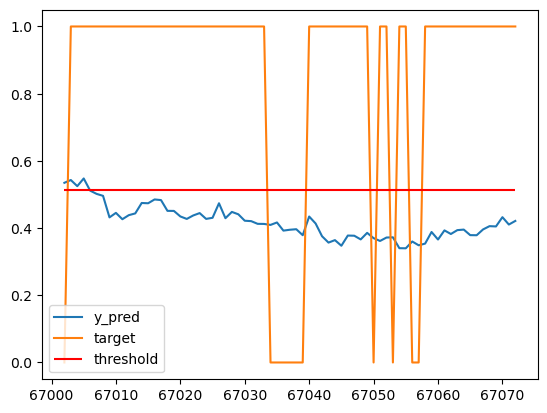

67003 SNGS
61


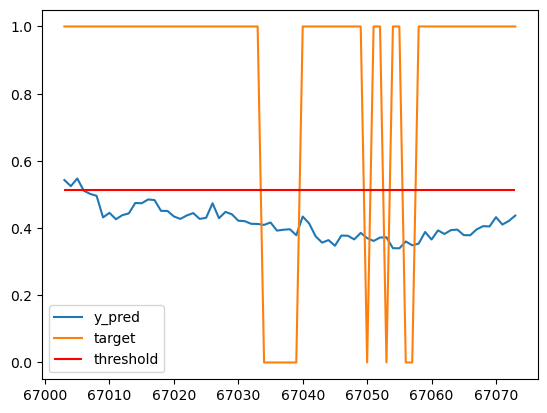

76665 SNGS
45


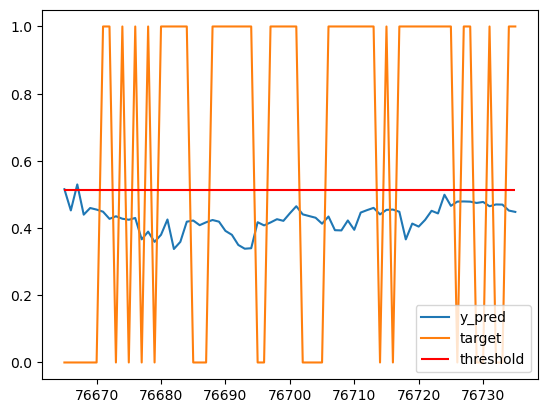

69996 SNGS
43


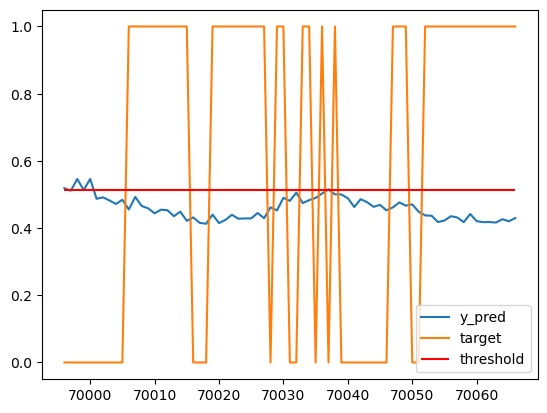

77178 SNGS
32


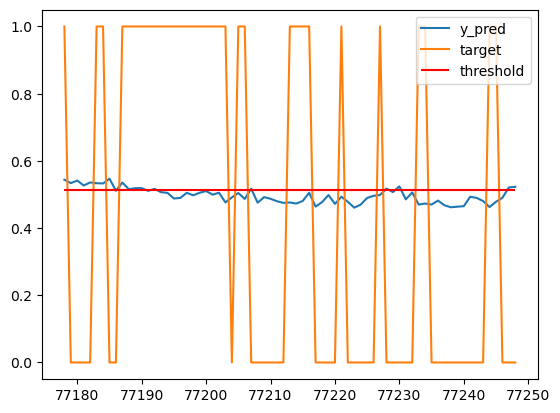

79621 SNGS
38


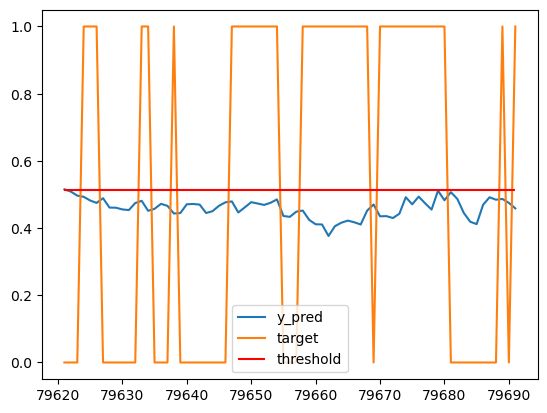

79619 SNGS
37


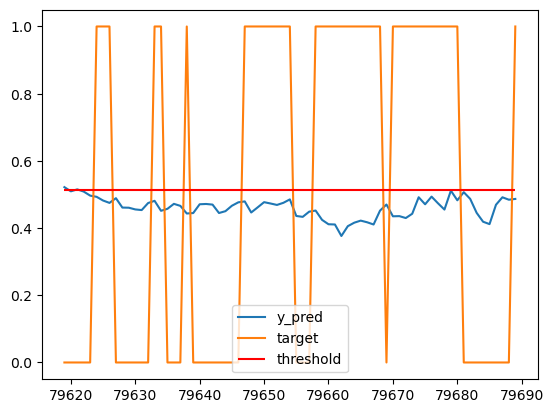

75436 SNGS
39


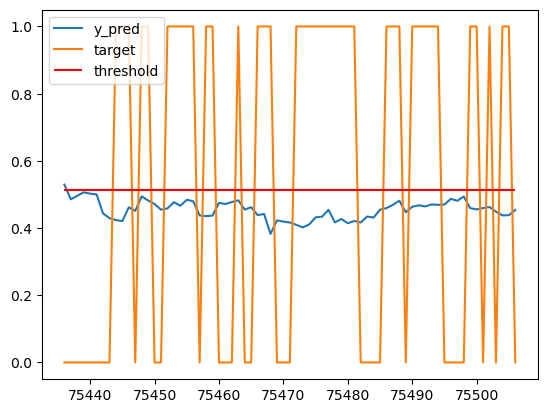

79732 SNGS
0


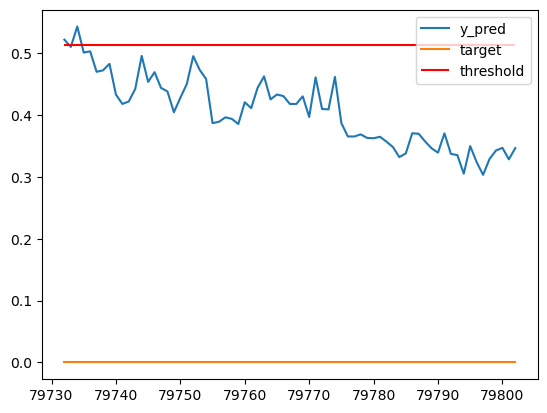

77132 SNGS
32


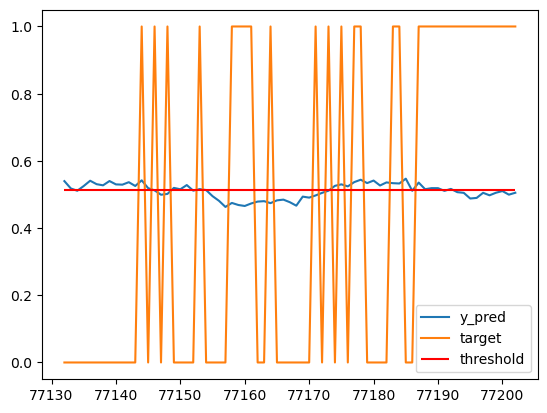

76643 SNGS
48


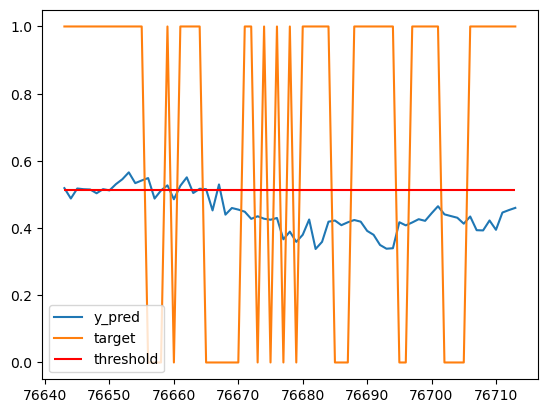

In [110]:
#bit threshold
mask = df['y_pred'] > threshold
inds = np.random.choice(df.index[(mask_valid|mask_test|mask_test2) & (mask)], size=20)



window = 14*5#неделя
for i in inds:
    print(i, df.loc[i, 'ticker'])
    print(df.loc[i:i+window, 'target'].sum())
    plt.plot(df.loc[i:i+window, 'y_pred'], label='y_pred')
    plt.plot(df.loc[i:i+window, 'target'], label='target')
    plt.hlines(threshold, i, i+window, color='red', label='threshold')
    plt.legend()
    plt.show()

### target24

In [428]:
# df

In [430]:
# df['result'].value_counts(normalize=True)

In [426]:
# df_result = load_pkl('./experiments/model_one_fc/df_result_wait_1day.pkl')
# df_result

In [432]:
# df_result['delta_time'] = df_result['delta_time'].replace(-1, pd.Timedelta('100 days'))
# mask = df_result['delta_time'] > pd.Timedelta('24 hours')
# df_result.loc[mask, 'result'] = 'DNF'

In [434]:
# df_result['result'].value_counts(normalize=True)

In [436]:
# df['target24'] = (df_result['result'] == 'WIN').astype(int)

In [438]:
# threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_valid&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test&mask, 'target24'].mean())

# threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
# mask = df['y_pred'] > threshold
# print(df.loc[mask_test2&mask, 'target24'].mean())

### Распределение вероятностей в целом

In [112]:
import warnings
warnings.filterwarnings('ignore')


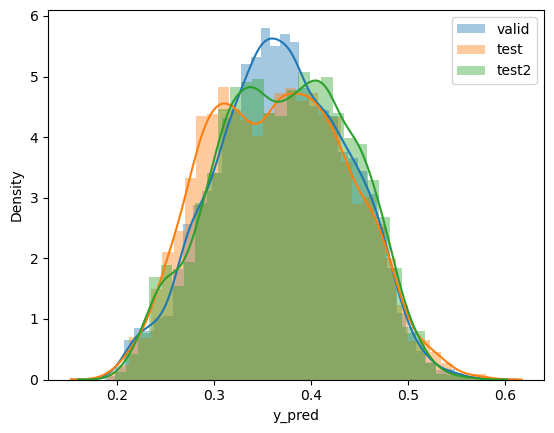

In [114]:

sns.distplot(df.loc[mask_valid, 'y_pred'], label='valid')
sns.distplot(df.loc[mask_test, 'y_pred'], label='test')
sns.distplot(df.loc[mask_test2, 'y_pred'], label='test2')
plt.legend()

In [116]:
#не так уж и плохо, есть надежды

### Распределение успеха (target) по бинам

[0.4983 0.5131]


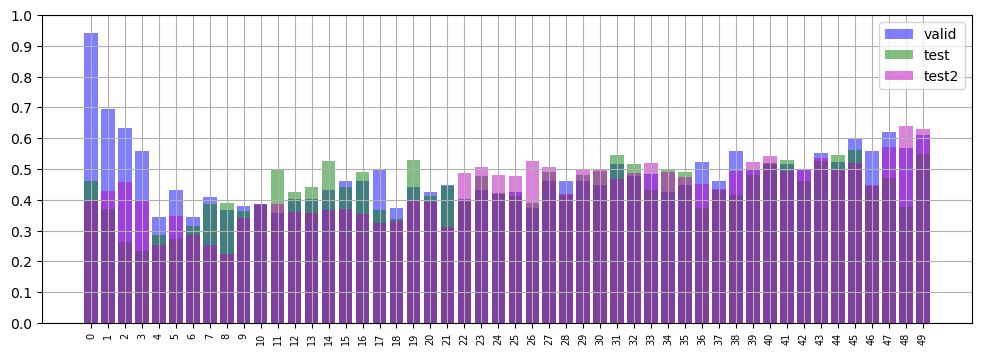

In [121]:
col_target = 'target'
q_count = 50



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


### Распределени успеха(target24) по бинам

In [126]:
# col_target = 'target24'
# q_count = 50

# print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

# df['bin'] = None

# df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
# q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
# df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


# df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
# df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


# df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
# df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

# plt.legend()
# plt.show()

In [128]:
pd.DataFrame(np.array([np.quantile(df.loc[mask_valid, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test2, 'y_pred'], q=np.arange(0.95, 1, 0.01))
                       
                      ]).T)

,0,1,2
0,0.47801,0.482072,0.480203
1,0.483351,0.488367,0.484249
2,0.489381,0.496143,0.490693
3,0.4983,0.507094,0.499056
4,0.513149,0.525316,0.510399
5,0.578542,0.580033,0.564383


In [130]:
#как-то через чур хорошо

### В разрезе тикеров (внутри каждого тикера своя вероятность)

In [134]:
def distplot(df, col_target=None, q_count=None):
    for ticker in df['ticker'].unique():
        print(ticker)
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'

        print(np.round(np.quantile(df_tk.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
        
        sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
        sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
        sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
        plt.legend()
        plt.show()



        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, labels=False)
        q = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)
        
        plt.figure(figsize=(12,4))

        df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
        
        df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
        plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
        plt.grid(visible=0.0001)
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xticks(np.arange(q_count), rotation=90, size=7)
        plt.legend()
        plt.show()
        

### таргет

SNGS
[0.4983 0.5131]


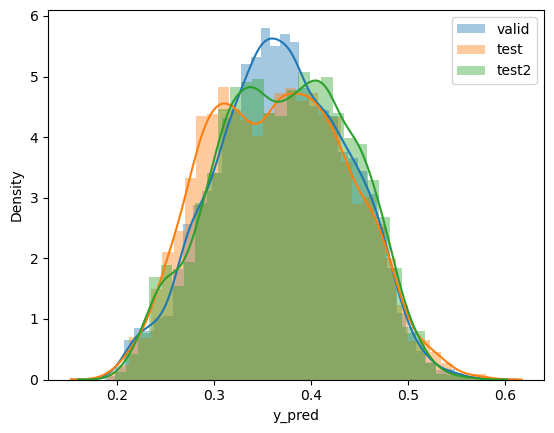

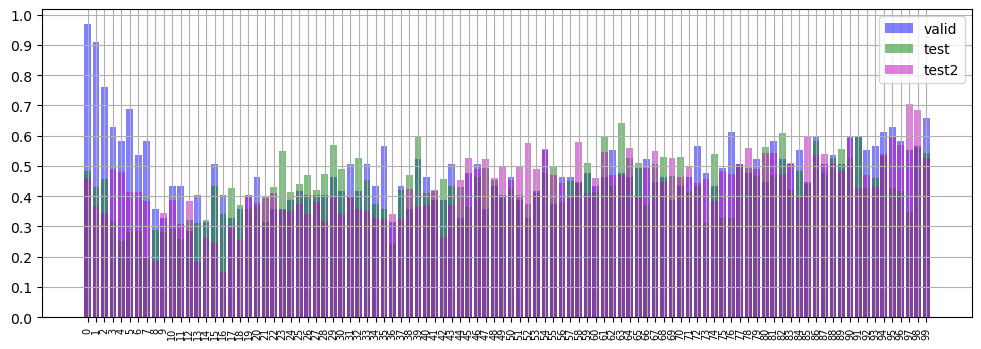

In [139]:
distplot(df, col_target='target',q_count=100)

In [110]:
#есть какие-то зацепки (Алроса, Магнит, СургутНГ)

### таргет24

In [115]:
#distplot(df, col_target='target24',q_count=50)

In [117]:
#Похоже, что искать свой попрог в каждой акции не лучшая идея

### Рассмотрим общий порог для всех акций

In [141]:
def distplot_common_threshold(df, col_target=None, q_count=None):

    mask_valid = df['sample'] == 'valid'
    q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
    
    for ticker in df['ticker'].unique():
        
        mask_valid = df['sample'] == 'valid'
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'
        




        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.cut(df_tk.loc[mask_valid, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_valid, 'bin'] = df_tk.loc[mask_valid, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        #df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

        if (df_tk['bin'] == q_count-1).sum() > 0:
            print(ticker)
            print(np.round(np.quantile(df.loc[df['sample'] == 'valid', 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
    

            
            sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
            sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
            sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
            plt.legend()
            plt.show()
        

            
        #print
            plt.figure(figsize=(12,4))
    
            df_tmp = df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)
            
            df_tmp = df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
            plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
            plt.grid(visible=0.0001)
            plt.yticks(np.arange(0, 1.1, 0.1))
            plt.xticks(np.arange(q_count), rotation=90, size=7)
            plt.legend()
            plt.show()

            mask_last_bin = df_tk['bin'] == q_count-1
            print(f'PRECISION: {round(df_tk.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
        
        



        
        

### общий порог, таргет

SNGS
[0.4983 0.5131]


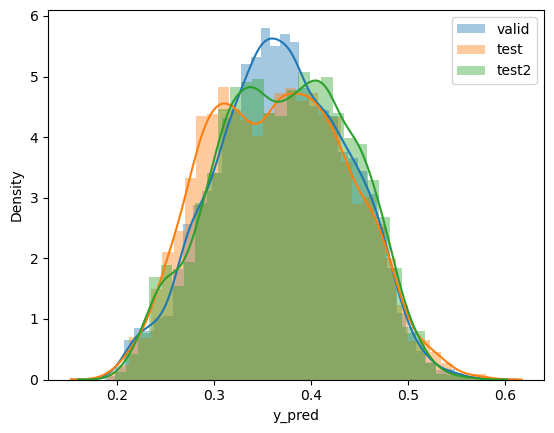

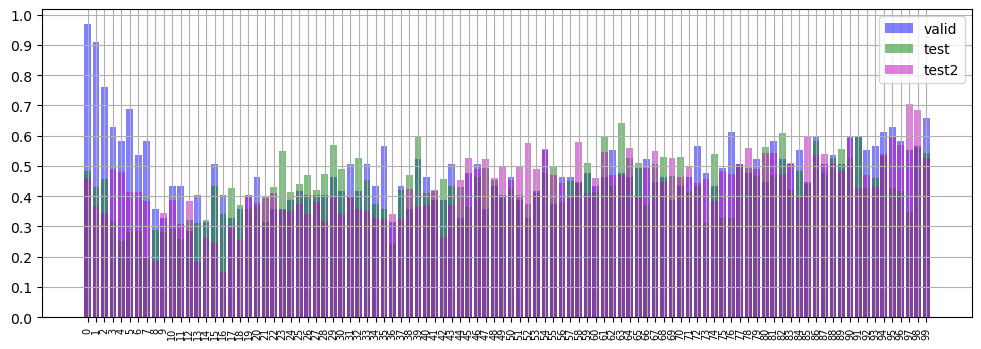

PRECISION: 0.66, 0.54, 0.53


In [146]:
distplot_common_threshold(df, col_target='target',q_count=100)

### общий порог, таргет12

In [408]:
# distplot_common_threshold(df, col_target='target24',q_count=50)

In [ ]:
#тут результаты плохие в разрезе акций

# Донастройка

In [128]:
# По сути интересен только 99-перцентиль

In [130]:
#И точек норм, магия какая-то

In [148]:
q=0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.5131492990255356
67 0.6567164179104478
67 0.6119402985074627
52 0.6153846153846154


In [151]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshold = {threshold}')

mask = df['y_pred'] > threshold
print((mask_valid&mask).sum(), df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test&mask).sum(),df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print((mask_test2&mask).sum(),df.loc[mask_test2&mask, 'target'].mean())

threshold = 0.5131492990255356
67 0.6567164179104478
116 0.5431034482758621
38 0.5263157894736842


[0.4983 0.5131]


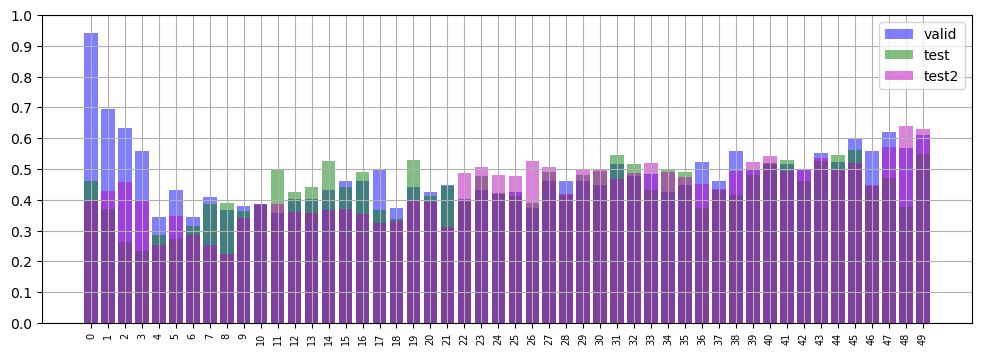

In [155]:
col_target = 'target'
q_count = 50



mask_valid = df['sample'] == 'valid'
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
#df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
#df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
#df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

#print
plt.figure(figsize=(12,4))
df_tmp = df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='valid', color='blue', alpha=0.5)

df_tmp = df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test', color='g', alpha=0.5)

df_tmp = df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().reset_index()
plt.bar(df_tmp['bin'], df_tmp['target'], label='test2', color='m', alpha=0.5)
plt.grid(visible=0.0001)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(q_count), rotation=90, size=7)
plt.legend()
plt.show()


In [157]:
def exp_smoothing(df, col_target, alpha, q=0.99):
    mask = df['sample'].notnull()
    y_pred = np.array(df.loc[mask, 'y_pred']).copy()

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'
    
    for i in range(1, y_pred.shape[0]):
        y_pred[i] = (1-alpha)*y_pred[i-1] + alpha*y_pred[i]
    
    df['y_pred_exp'] = None
    df.loc[mask, 'y_pred_exp'] = y_pred


    
    threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=q)
    mask_last_bin = df['y_pred_exp'] > threshold
    
    print(f'ALPHA = {round(alpha,3)}, PRECISION: {round(df.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
    

### таргет

In [171]:
for alpha in np.arange(0.1, 1.1, 0.1):
    exp_smoothing(df, 'target', alpha, q=0.98)

ALPHA = 0.1, PRECISION: 0.81, 0.43, 0.68
ALPHA = 0.2, PRECISION: 0.73, 0.5, 0.67
ALPHA = 0.3, PRECISION: 0.7, 0.5, 0.65
ALPHA = 0.4, PRECISION: 0.69, 0.5, 0.65
ALPHA = 0.5, PRECISION: 0.68, 0.52, 0.65
ALPHA = 0.6, PRECISION: 0.65, 0.53, 0.66
ALPHA = 0.7, PRECISION: 0.64, 0.52, 0.66
ALPHA = 0.8, PRECISION: 0.61, 0.52, 0.64
ALPHA = 0.9, PRECISION: 0.62, 0.54, 0.62
ALPHA = 1.0, PRECISION: 0.61, 0.55, 0.63


In [171]:
# for alpha in np.arange(0.01, 1, 0.01):
#     exp_smoothing(df, 'target', alpha, q=0.99)

In [166]:
# for alpha in np.arange(0.005, 0.05, 0.005):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [167]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target', alpha, q=0.995)

In [ ]:
#ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56

In [ ]:
#И сколько их в день интересно? И на каких акциях?

In [ ]:
#Разные варианты

In [163]:
exp_smoothing(df, 'target', 0.9, q=0.98)

ALPHA = 0.9, PRECISION: 0.62, 0.54, 0.62


In [165]:
exp_smoothing(df, 'target', 0.9, q=0.99)

ALPHA = 0.9, PRECISION: 0.64, 0.54, 0.56


In [173]:
exp_smoothing(df, 'target', 0.9, q=0.995)


ALPHA = 0.9, PRECISION: 0.65, 0.6, 0.6


In [175]:
mask_valid = df['sample'] == 'valid'
threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=0.995)
threshold

0.5231834718418996

In [178]:
mask_threshold = df['y_pred_exp']  > threshold

mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_threshold].shape[0], df.loc[mask_test&mask_threshold].shape[0], df.loc[mask_test2&mask_threshold].shape[0]

(34, 70, 20)

In [180]:
df.loc[mask_valid&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_threshold, 'time'].dt.date.nunique()

(7, 6, 5)

In [182]:
df.loc[mask_valid&mask_threshold, 'ticker'].unique(), df.loc[mask_test&mask_threshold, 'ticker'].unique(), df.loc[mask_test2&mask_threshold, 'ticker'].unique()

(array(['SNGS'], dtype=object),
 array(['SNGS'], dtype=object),
 array(['SNGS'], dtype=object))

In [ ]:
#SNGS, MAGN, RUAL

In [ ]:
#Разъеб!!!

### таргет (доп для моделей <1 дня)

In [148]:
# for alpha in np.arange(0.1, 1.1, 0.1):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [150]:
# for alpha in np.arange(0.01, 0.11, 0.01):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [152]:
# for alpha in np.arange(0.001, 0.011, 0.001):
#     exp_smoothing(df, 'target24', alpha, q=0.995)

In [ ]:
#ALPHA = 0.005, PRECISION: 0.53, 0.55, 0.58